In [1]:
import rootutils
from pathlib import Path

rootutils.setup_root(Path.cwd(), indicator=".project-root", pythonpath=True)
import numpy as np
from src.viaABC.systems import LotkaVolterra
from src.models.lightning_module import PreTrainLightning
from src.models.MAE.model import MaskedAutoencoderViT
import torch

from src.utils.viaABC_utils.inference_utils import load_pretrained_model
from hydra.utils import instantiate
from omegaconf import OmegaConf
import os

/home/jp4474/viaABC/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf

chkpt_path = "/home/jp4474/viaABC/logs/train/runs/2025-12-05_09-00-15"

with initialize_config_dir(config_dir=os.path.join(chkpt_path, ".hydra")):
    cfg = compose(config_name="config")

/tmp/ipykernel_915595/1593070090.py:6: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize_config_dir(config_dir=os.path.join(chkpt_path, ".hydra")):


In [4]:
model = instantiate(cfg.model)
# Load raw checkpoint
ckpt = torch.load(Path(chkpt_path) / "checkpoints/epoch_086.ckpt", map_location="cpu", weights_only=False)

state = ckpt["state_dict"]


# 1. strip 'model.' prefix (Lightning adds this)
# 2. strip '_orig_mod.' from DDP/Fabric models  
fixed_state = {}

for k, v in state.items():
    new_k = k

    # remove top-level "model."
    if new_k.startswith("model."):
        new_k = new_k[len("model."):]

    # remove DDP wrapper
    if new_k.startswith("_orig_mod."):
        new_k = new_k[len("_orig_mod."):]

    fixed_state[new_k] = v

missing, unexpected = model.model.load_state_dict(fixed_state, strict=False)

print("Missing:", missing)
print("Unexpected:", unexpected)
print("✓ Loaded successfully with prefix-stripping")

Missing: []
Unexpected: []
✓ Loaded successfully with prefix-stripping


In [5]:
def strip_orig_mod(state_dict):
    new_state = {}
    for k, v in state_dict.items():
        if k.startswith("model._orig_mod."):
            new_k = k.replace("model._orig_mod.", "model.")
        elif k.startswith("_orig_mod."):
            new_k = k.replace("_orig_mod.", "")
        else:
            new_k = k
        new_state[new_k] = v
    return new_state

In [6]:
from src.data.transforms import GramianAngularField

In [7]:
lotka_abc = LotkaVolterra(model=model, pooling_method='no_cls', metric="pairwise_cosine", transform=GramianAngularField())

INFO:src.viaABC.viaABC:Initializing viaABC class
INFO:src.viaABC.viaABC:Model updated
INFO:src.viaABC.viaABC:viaABC class initialized with the following parameters:
INFO:src.viaABC.viaABC:num_parameters: 2
INFO:src.viaABC.viaABC:Mu: [0 0]
INFO:src.viaABC.viaABC:Sigma: [10 10]
INFO:src.viaABC.viaABC:t0: 0
INFO:src.viaABC.viaABC:tmax: 15
INFO:src.viaABC.viaABC:time_space: [ 1.1  2.4  3.9  5.6  7.5  9.6 11.9 14.4]
INFO:src.viaABC.viaABC:pooling_method: no_cls
INFO:src.viaABC.viaABC:metric: pairwise_cosine


In [8]:
transform = GramianAngularField()
transform(lotka_abc.raw_observational_data).shape

torch.Size([4, 8, 8])

In [46]:
x = lotka_abc.simulate([1.2,1.1])[0]

In [54]:
with torch.no_grad():
    _, _, pred = model.model(transform(x).to(torch.float32).unsqueeze(0), mask_ratio=0.0)

In [55]:
pred_np = model.model.unpatchify(pred).squeeze(0).cpu().numpy()

In [56]:
pred_np.shape

(4, 8, 8)

In [57]:
pred_np.shape

(4, 8, 8)

In [58]:
original_np = transform(x)

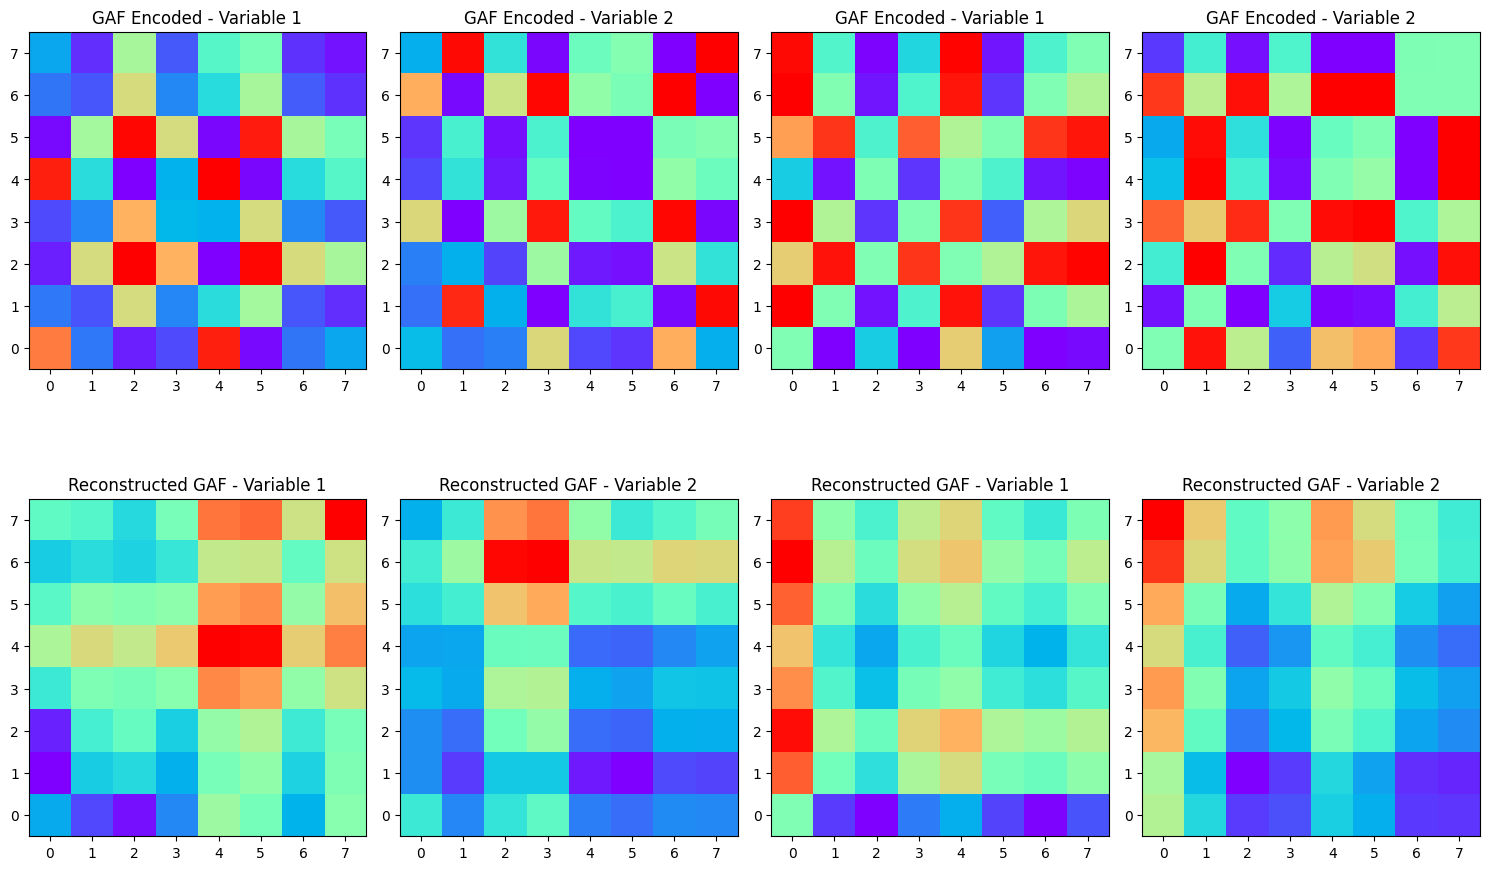

In [59]:
# plot line-graph on first row, raw GAF on second row, reconstructed GAF on third row
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 4, figsize=(15, 10))

axs[0, 0].imshow(original_np[0], cmap='rainbow', origin='lower')
axs[0, 0].set_title("GAF Encoded - Variable 1")
axs[0, 1].imshow(original_np[1], cmap='rainbow', origin='lower')
axs[0, 1].set_title("GAF Encoded - Variable 2")
axs[0, 2].imshow(original_np[2], cmap='rainbow', origin='lower')
axs[0, 2].set_title("GAF Encoded - Variable 1")
axs[0, 3].imshow(original_np[3], cmap='rainbow', origin='lower')
axs[0, 3].set_title("GAF Encoded - Variable 2")

axs[1, 0].imshow(pred_np[0], cmap='rainbow', origin='lower')
axs[1, 0].set_title("Reconstructed GAF - Variable 1")
axs[1, 1].imshow(pred_np[1], cmap='rainbow', origin='lower')
axs[1, 1].set_title("Reconstructed GAF - Variable 2")
axs[1, 2].imshow(pred_np[2], cmap='rainbow', origin='lower')
axs[1, 2].set_title("Reconstructed GAF - Variable 1")
axs[1, 3].imshow(pred_np[3], cmap='rainbow', origin='lower')
axs[1, 3].set_title("Reconstructed GAF - Variable 2")

plt.tight_layout()
plt.show()

In [61]:
lotka_abc.run(num_particles=200, k=10, q_threshold=0.999)

INFO:src.viaABC.viaABC:Starting viaABC run with Q Threshold: 0.999
INFO:src.viaABC.viaABC:Initialization (generation 0) started
INFO:src.viaABC.viaABC:Initialization completed in 10.67 seconds
INFO:src.viaABC.viaABC:Mean: [2.5241 1.8501]
INFO:src.viaABC.viaABC:Median: [2.2246 1.4649]
INFO:src.viaABC.viaABC:Variance: [4.3127 2.6315]
INFO:src.viaABC.viaABC:Generation 1 started
100%|██████████| 200/200 [00:05<00:00, 34.80it/s]
INFO:src.viaABC.viaABC:Epsilon : 0.46273
INFO:src.viaABC.viaABC:Quantile : 0.71926
INFO:src.viaABC.viaABC:Simulations : 813
INFO:src.viaABC.viaABC:Mean: [2.6109 1.7643]
INFO:src.viaABC.viaABC:Median: [2.3551 1.3961]
INFO:src.viaABC.viaABC:Variance: [4.1482 1.6008]
INFO:src.viaABC.viaABC:Generation 1 completed in 6.51 seconds
INFO:src.viaABC.viaABC:Generation 2 started
100%|██████████| 200/200 [00:06<00:00, 32.34it/s]
INFO:src.viaABC.viaABC:Epsilon : 0.43193
INFO:src.viaABC.viaABC:Quantile : 0.76772
INFO:src.viaABC.viaABC:Simulations : 901
INFO:src.viaABC.viaABC:Mean